In [1]:
from fit.datamodules.tomo_rec.TRecDataModule import LoDoPaBFourierTargetDataModule
from fit.utils import convert2FC, fft_interpolate, psfft, convert_to_dft, PSNR
from fit.utils.tomo_utils import get_proj_coords_pol, get_img_coords_pol, pol2cart

from matplotlib import pyplot as plt

import torch

import numpy as np

from skimage.transform import iradon

from matplotlib import pyplot as plt

In [2]:
img_shape = 111
num_angles = 17

In [3]:
dm = LoDoPaBFourierTargetDataModule(batch_size=4, gt_shape=img_shape, num_angles=num_angles)

In [4]:
dm.setup()

In [5]:
train_dl = dm.train_dataloader()

In [6]:
n = 2
i = 0
for sino, img  in train_dl.dataset.ds:
    if i >= n:
        break
    i+=1

In [7]:
img.shape

torch.Size([111, 111])

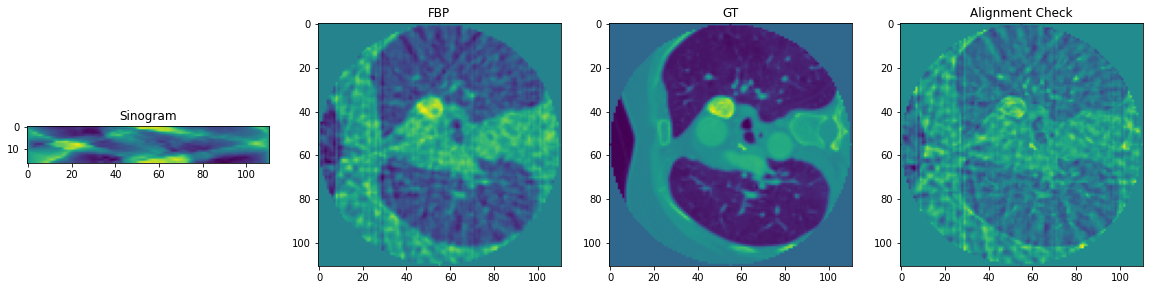

In [8]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(sino)
plt.title('Sinogram');
plt.subplot(1,4,2)
rec = iradon(sino.numpy().T, theta=np.rad2deg(-dm.gt_ds.get_ray_trafo().geometry.angles), circle=True,
                 output_size=img_shape).T
plt.imshow(rec)
plt.title('FBP');
plt.subplot(1,4,3)
plt.imshow(img)
plt.title('GT');
plt.subplot(1,4,4)
plt.imshow(img - rec)
plt.title('Alignment Check');

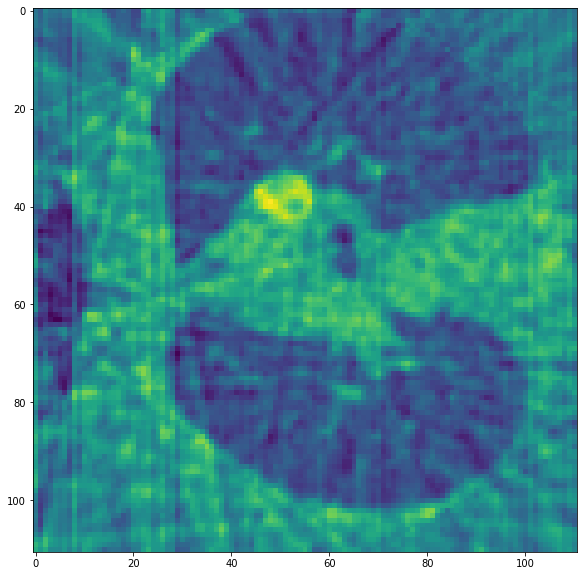

In [9]:
rec = iradon(sino.numpy().T, theta=np.rad2deg(-dm.gt_ds.get_ray_trafo().geometry.angles), circle=False,
                 output_size=img_shape).T
plt.figure(figsize=(10,10))
plt.imshow(rec)

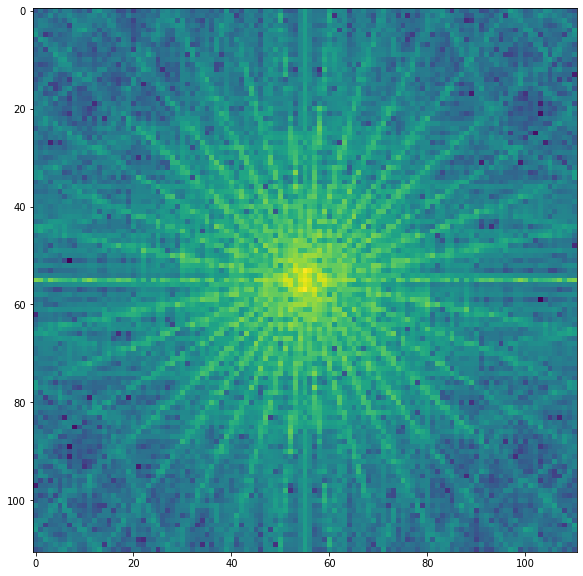

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fftn(rec)))))

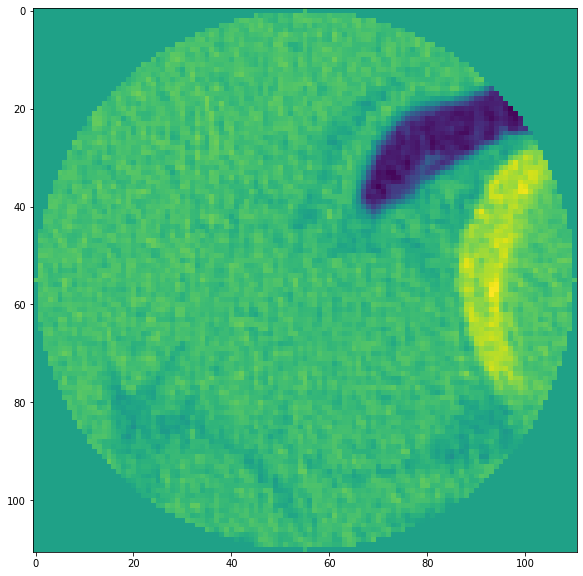

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(img)

In [8]:
for x, y, y_real, (mag_min, mag_max) in train_dl:
    break

In [9]:
x_fc = convert2FC(x, mag_min, mag_max)
y_fc = convert2FC(y, mag_min, mag_max)

In [10]:
det_len = dm.gt_ds.get_ray_trafo().geometry.detector.shape[0]
print(det_len)

359


In [11]:
# Computing the projection and target Fourier coefficient coordinates
srcx, srcy, src_flatten_order = get_proj_coords(angles=dm.gt_ds.get_ray_trafo().geometry.angles, 
                                                det_len=det_len)
dstx, dsty, dst_flatten_order, order = get_img_coords(img_shape=img_shape, 
                                                      det_len=det_len)
target_shape = order.shape
print('Fourier Space Shape:', target_shape)

Fourier Space Shape: (361, 181)


In [12]:
bin_factor = 15
shells = (det_len//2+1)/bin_factor
num_sino_fcs = np.clip(num_angles*int(shells + 1), 1, x_fc.shape[1])
num_target_fcs =  np.sum(order <= shells) if bin_factor > 1 else y_fc.shape[1]

In [13]:
# Interpolate target Fourier coefficients based on projection Fourier coefficients --> Fourier Slice Theorem
i = 0
fc = x_fc[i][src_flatten_order]
fc[num_sino_fcs:] = 1
x_dft = fft_interpolate(srcx, srcy, dstx, dsty, fc, 
                        target_shape=target_shape, dst_flatten_order=dst_flatten_order)

In [14]:
y_fc_ = y_fc[i].numpy().flatten()[dst_flatten_order]
y_fc_[num_target_fcs:] = 1
y_fc_[dst_flatten_order] = y_fc_.flatten()

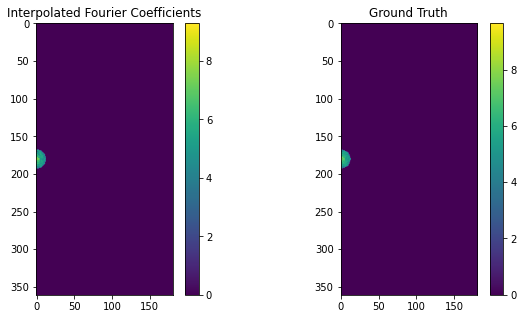

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.roll(np.log(np.abs(x_dft)), x_dft.shape[0]//2, 0))
plt.colorbar()
plt.title('Interpolated Fourier Coefficients');
plt.subplot(1,2,2)
plt.imshow(np.roll(np.log(np.abs(y_fc_.reshape(target_shape))), img_shape//2, 0))
plt.colorbar()
plt.title('Ground Truth');

In [16]:
print('#Inputs: {}/{}={:1.3f}'.format(num_sino_fcs, x_fc.shape[1], num_sino_fcs/x_fc.shape[1]))
print('#Targets: {}/{}={:1.3f}'.format(num_target_fcs, y_fc.shape[1], num_target_fcs/y_fc.shape[1]))

#Inputs: 780/10800=0.072
#Targets: 241/65341=0.004


In [17]:
mask = psfft(bin_factor, pixel_res=img_shape).numpy()

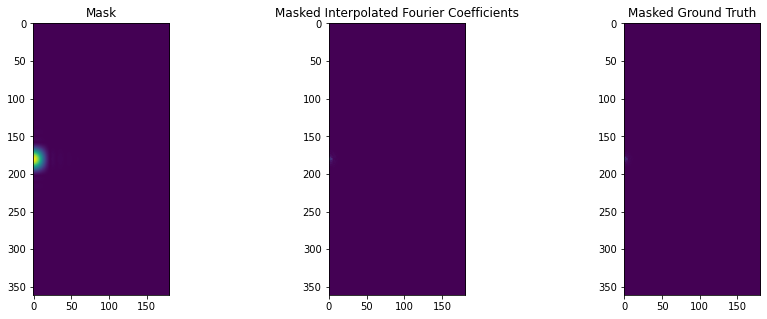

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(np.roll(np.abs(mask), img_shape//2, 0))
plt.title('Mask')
plt.subplot(1,3,2)
plt.imshow(np.roll(np.abs(x_dft*mask), img_shape//2, 0))
plt.title('Masked Interpolated Fourier Coefficients');
plt.subplot(1,3,3)
plt.imshow(np.roll(np.abs(y_fc_.reshape(img_shape, img_shape//2 + 1) * mask), img_shape//2, 0))
plt.title('Masked Ground Truth');

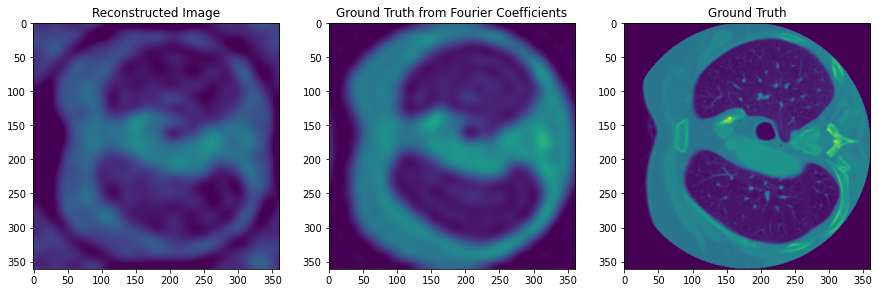

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
rec_img = np.roll(np.fft.irfftn(x_dft*mask, s=2*(img_shape,)), 2*(img_shape//2,), (0, 1))
plt.imshow(rec_img, vmin=y_real[i].min().item(), vmax=y_real[i].max().item())
plt.title('Reconstructed Image');
plt.subplot(1,3,2)
y_target = np.roll(np.fft.irfftn(y_fc_.reshape(*target_shape)*mask, s=2*(img_shape,)), 2*(img_shape//2,), (0, 1))
plt.imshow(y_target, vmin=y_real[i].min().item(), vmax=y_real[i].max().item())
plt.title('Ground Truth from Fourier Coefficients');
plt.subplot(1,3,3)
plt.imshow(y_real[i], vmin=y_real[i].min().item(), vmax=y_real[i].max().item())
plt.title('Ground Truth');